## Importing the libraries

In [1]:
import numpy as np
from astropy.io import fits
import extinction
import pyregion
import aplpy
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.nonparametric.smoothers_lowess import lowess

## Apply Sky background subtraction 

In [2]:
# Function to read DS9 region file
def read_ds9_region(region_file):
    regions = pyregion.open(region_file)
    return regions

# Function to extract region data from data cube
def extract_region_data(data_cube, regions, header):
    mask = regions.get_mask(hdu=fits.PrimaryHDU(header=header, data=data_cube[0]))
    masked_data_cube = np.where(mask == 0, np.nan, data_cube)  # Replace zeros with NaN
    return masked_data_cube

# Function to integrate the spectrum
def sky_spectrum_task(region_data):
    sky_spectrum = np.nanmedian(region_data, axis=(1, 2))
    return sky_spectrum

with fits.open('2912251z.fits') as hdul_uncorrected:
    uncorrected_data_cube = hdul_uncorrected[0].data
    header_uncorrected = hdul_uncorrected[0].header
    
region_file = 'sky_cube_1.reg'  # Replace with your DS9 region file
regions = read_ds9_region(region_file)

# Extract region data
masked_data = extract_region_data(uncorrected_data_cube, regions, header_uncorrected)

sky_spec = sky_spectrum_task(masked_data)

# Perform the sky subtraction
sky_subtracted_cube = uncorrected_data_cube - sky_spec[:, np.newaxis, np.newaxis]

# Save the corrected data cube to a new FITS file
new_header = header_uncorrected.copy()
new_header.add_history('Sky background correction applied')
fits.writeto('sky-corrected_data_cube.fits', sky_subtracted_cube, new_header, overwrite=True)

## Apply Extinction Correction

In [3]:
# Open the FITS file, extract the data cube and header
with fits.open('sky-corrected_data_cube.fits') as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

# Check if data_cube is properly loaded
if data_cube is None:
    raise ValueError("Data cube is empty or not loaded correctly.")

# Wavelength information from the hierarchical keywords
filter_cm1_min = header['HIERARCH filter_cm1_min']
filter_cm1_max = header['HIERARCH filter_cm1_max']
step_nb = header['STEP_NB']

# Specify the wavenumber array (in cm^-1)
wavenumber_axis = np.linspace(filter_cm1_min, filter_cm1_max, step_nb)

# Convert wavenumber (cm^-1) to wavelength (Angstroms)
wavelength_axis = 1e8 / wavenumber_axis  # Convert cm^-1 to Angstroms

# Extinction law parameters
R_v = 3.1  # Typical value for the Milky Way
E_BV = 0.52  # From SOLLERMAN et al. (2000)
A_V = R_v * E_BV

# Calculate extinction correction factor using Fitzpatrick (1999) law
extinction_curve = extinction.fitzpatrick99(wavelength_axis, A_V)
correction_factor = 10**(0.4 * extinction_curve)

# Apply correction to the data cube along the wavelength axis (flux correction)
corrected_data_cube = data_cube * correction_factor[:, np.newaxis, np.newaxis]

# Save the corrected data cube to a new FITS file
new_header = header.copy()
new_header.add_history('Extinction and reddening correction applied')
fits.writeto('corrected_data_cube.fits', corrected_data_cube, new_header, overwrite=True)

In [29]:
with fits.open('sky-corrected_data_cube.fits') as hdul:
    t_cube = hdul[0].data
    #header = hdul[0].header
print(np.shape(t_cube))

(113, 2064, 2048)


In [39]:
from extinction import remove

t = extinction.fitzpatrick99(wavelength_axis, A_V, R_v)
corr = remove(t, t_cube[:,1500,1500])

tt = extinction.fitzpatrick99(wavelength_axis[25:80], A_V, R_v)
corrr = remove(tt, t_cube[25:80,1500,1500])

In [35]:
cor = t_cube[:,1500,1500] * correction_factor[:]

In [ ]:
np.shape()

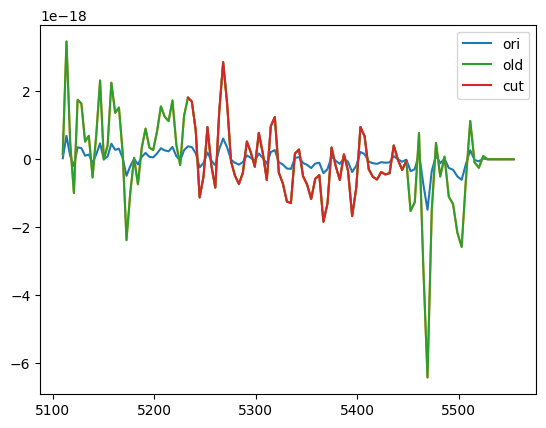

In [43]:
plt.plot(wavelength_axis,t_cube[:,1500,1500], label="ori")
plt.plot(wavelength_axis,corr)
plt.plot(wavelength_axis,cor, label="old")
plt.plot(wavelength_axis[25:80], corrr,label="cut")
plt.legend()

## Visual comparison with the curves before and after extiction correction

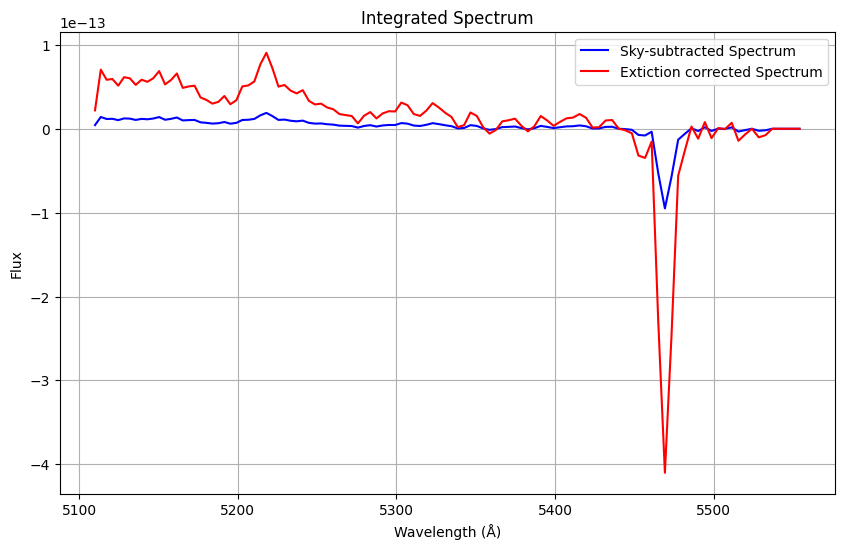

In [8]:
# Function to read DS9 region file
def read_ds9_region(region_file):
    regions = pyregion.open(region_file)
    return regions

# Function to extract region data from data cube
def extract_region_data(data_cube, regions, header):
    mask = regions.get_mask(hdu=fits.PrimaryHDU(header=header, data=data_cube[0]))
    masked_data_cube = data_cube * mask
    return masked_data_cube

# Function to integrate the spectrum
def integrate_spectrum(region_data):
    integrated_spectrum = np.nansum(region_data, axis=(1, 2))
    return integrated_spectrum

def plot_2spectrum(corrected_spectrum, uncorrected_spectrum, header):
    filter_cm1_min = header['HIERARCH filter_cm1_min']
    filter_cm1_max = header['HIERARCH filter_cm1_max']
    step_nb = header['STEP_NB']

    wavenumber_axis = np.linspace(filter_cm1_min, filter_cm1_max, step_nb)
    wavelength_axis = 1e8 / wavenumber_axis  # Convert cm^-1 to Angstroms

    plt.figure(figsize=(10, 6))
    plt.plot(wavelength_axis, corrected_spectrum, label='Sky-subtracted Spectrum', color='blue')
    plt.plot(wavelength_axis, uncorrected_spectrum, label='Extiction corrected Spectrum', color='red')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.title('Integrated Spectrum')
    plt.legend()
    plt.grid(True)
    #plt.savefig('spectra_extinction_corrected_region_6')
    plt.show()

with fits.open('sky-corrected_data_cube.fits') as hdul_corrected:
    corrected_data_cube = hdul_corrected[0].data
    header_corrected = hdul_corrected[0].header
    
with fits.open('corrected_data_cube.fits') as hdul_uncorrected:
    uncorrected_data_cube = hdul_uncorrected[0].data
    header_uncorrected = hdul_uncorrected[0].header

region_file = '../Luci_outputs/field_1_regions_paper/region2.reg'  # Replace with your DS9 region file
regions = read_ds9_region(region_file)

# Extract region data
corrected_region_data = extract_region_data(corrected_data_cube, regions, header_corrected)
uncorrected_region_data = extract_region_data(uncorrected_data_cube, regions, header_uncorrected)

# Integrate spectra
corrected_spectrum = integrate_spectrum(corrected_region_data)
uncorrected_spectrum = integrate_spectrum(uncorrected_region_data)

# Plot spectra
plot_2spectrum(corrected_spectrum, uncorrected_spectrum, header_corrected)

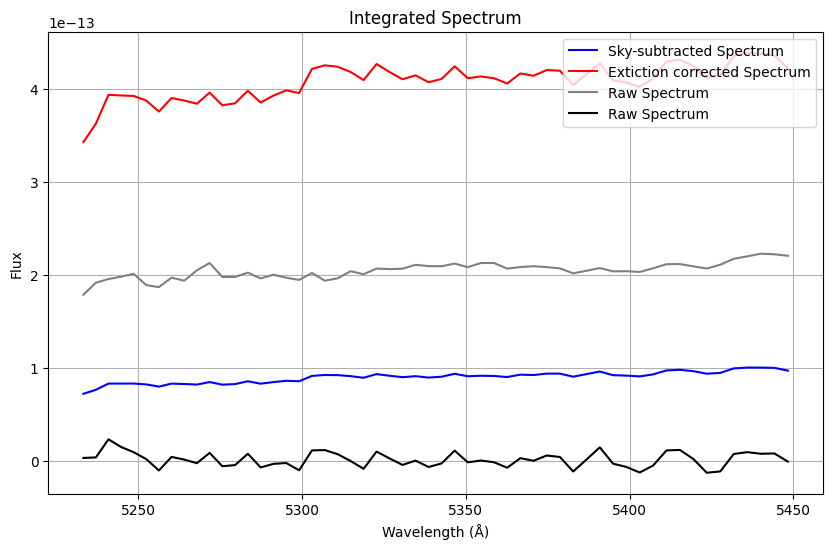

In [19]:
# COPY

# Function to read DS9 region file
def read_ds9_region(region_file):
    regions = pyregion.open(region_file)
    return regions

# Function to extract region data from data cube
def extract_region_data(data_cube, regions, header):
    mask = regions.get_mask(hdu=fits.PrimaryHDU(header=header, data=data_cube[0]))
    masked_data_cube = data_cube * mask
    return masked_data_cube

# Function to integrate the spectrum
def integrate_spectrum(region_data):
    integrated_spectrum = np.nansum(region_data, axis=(1, 2))
    return integrated_spectrum

def plot_4spectrum(corrected_spectrum, uncorrected_spectrum, raw_spectrum, contSub, header):
    filter_cm1_min = header['HIERARCH filter_cm1_min']
    filter_cm1_max = header['HIERARCH filter_cm1_max']
    step_nb = header['STEP_NB']

    wavenumber_axis = np.linspace(filter_cm1_min, filter_cm1_max, step_nb)
    wavelength_axis = 1e8 / wavenumber_axis  # Convert cm^-1 to Angstroms

    plt.figure(figsize=(10, 6))
    plt.plot(wavelength_axis[25:80], corrected_spectrum[25:80], label='Sky-subtracted Spectrum', color='blue')
    plt.plot(wavelength_axis[25:80], uncorrected_spectrum[25:80], label='Extiction corrected Spectrum', color='red')
    plt.plot(wavelength_axis[25:80], raw_spectrum[25:80], label='Raw Spectrum', color='grey')
    plt.plot(wavelength_axis[25:80], contSub_spectrum[25:80], label='Raw Spectrum', color='black')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.title('Integrated Spectrum')
    plt.legend()
    plt.grid(True)
    plt.savefig('plot_region7.png')
    plt.show()

with fits.open('2912251z.fits') as hdul_raw:
    raw_data_cube = hdul_raw[0].data
    header_raw = hdul_raw[0].header
    
with fits.open('sky-corrected_data_cube.fits') as hdul_corrected:
    corrected_data_cube = hdul_corrected[0].data
    header_corrected = hdul_corrected[0].header
    
with fits.open('corrected_data_cube.fits') as hdul_uncorrected:
    uncorrected_data_cube = hdul_uncorrected[0].data
    header_uncorrected = hdul_uncorrected[0].header

with fits.open('continuum_subtracted.fits') as hdul_contSub:
    contSub_data_cube = hdul_contSub[0].data
    header_contSub = hdul_contSub[0].header    

region_file = '../Luci_outputs/field_1_regions_paper/region7.reg'  # Replace with your DS9 region file
regions = read_ds9_region(region_file)

# Extract region data
corrected_region_data = extract_region_data(corrected_data_cube, regions, header_corrected)
uncorrected_region_data = extract_region_data(uncorrected_data_cube, regions, header_uncorrected)
raw_region_data = extract_region_data(raw_data_cube, regions, header_raw)
contSub_region_data = extract_region_data(contSub_data_cube, regions, header_contSub)

# Integrate spectra
corrected_spectrum = integrate_spectrum(corrected_region_data)
uncorrected_spectrum = integrate_spectrum(uncorrected_region_data)
raw_spectrum = integrate_spectrum(raw_region_data)
contSub_spectrum = integrate_spectrum(contSub_region_data)

# Plot spectra
plot_4spectrum(corrected_spectrum, uncorrected_spectrum, raw_spectrum, contSub_spectrum, header_corrected)

## Extract spectrum from a certain region

100%|█████████████████████████████████████| 2064/2064 [00:00<00:00, 2983.20it/s]


enter region number: 1


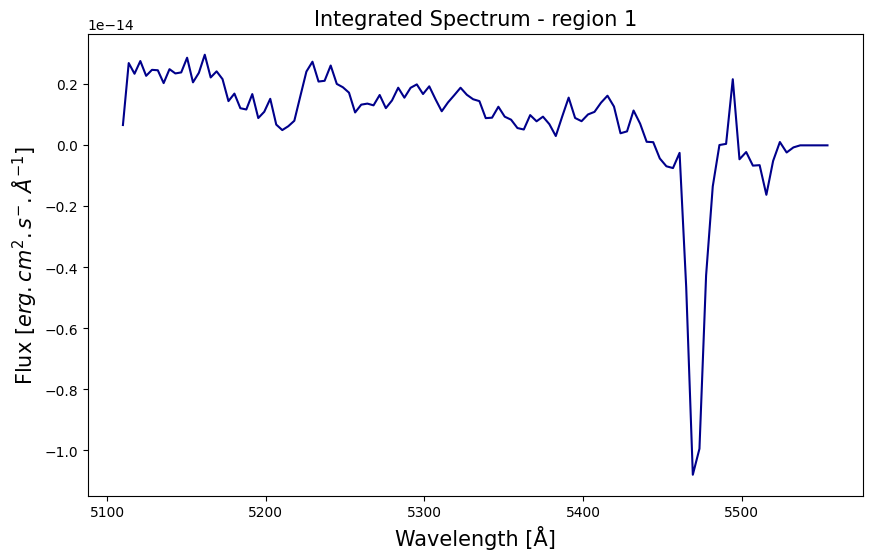

In [6]:

# Here I re-wrote the functions because I didn`t want to re-fit the cube again..
def read_ds9_region(region_file):
    regions = pyregion.open(region_file)
    return regions

# Function to extract region data from data cube
def extract_region_data(data_cube, regions, header):
    mask = regions.get_mask(hdu=fits.PrimaryHDU(header=header, data=data_cube[0]))
    return mask

# Function to integrate the spectrum
def integrate_spectrum(data_cube, mask, mean=False):
    integrated_spectrum = np.zeros(data_cube.shape[0])
    spec_ct = 0
    for i in tqdm(range(data_cube.shape[1])):
        for j in range(data_cube.shape[2]):
            if mask[i, j]:
                integrated_spectrum += data_cube[:, i, j]
                spec_ct += 1
    if mean:
        integrated_spectrum /= spec_ct
    return integrated_spectrum

def save_spectrum(wavelength_axis, integrated_spectrum_per_angstrom, filename):
    with open(filename, 'w') as f:
        f.write("# Wavelength (Å)  Flux (ergs/cm^2/s/Å)\n")
        for wavelength, flux in zip(wavelength_axis, integrated_spectrum_per_angstrom):
            f.write(f"{wavelength:.5f} {flux:.5e}\n")

# Function to plot the spectrum
def plot_spectrum(integrated_spectrum, header,figname):
    filter_cm1_min = header['HIERARCH filter_cm1_min']
    filter_cm1_max = header['HIERARCH filter_cm1_max']
    step_nb = header['STEP_NB']

    wavenumber_axis = np.linspace(filter_cm1_min, filter_cm1_max, step_nb)
    wavelength_axis = 1e8 / wavenumber_axis  # Convert cm^-1 to Angstroms

    # Calculate the wavelength step size
    wavelength_step = np.abs(np.diff(wavelength_axis)).mean()  # Mean step size in Ångstroms

    # Convert integrated spectrum to erg/cm^2/s/Å
    integrated_spectrum_per_angstrom = integrated_spectrum / wavelength_step
    save_spectrum(wavelength_axis, integrated_spectrum_per_angstrom, 'region_1_spec.txt')

    plt.figure(figsize=(10, 6))
    plt.plot(wavelength_axis, integrated_spectrum_per_angstrom, label='Integrated Spectrum',color='darkblue')
    plt.xlabel('Wavelength [Å]',size=15)
    plt.ylabel('Flux [$erg.cm^2.s^{-}.{\AA}^{-1}$]',size=15)
    title = 'Integrated Spectrum - region ' + input('enter region number: ')
    plt.title(title, size=15)
    #plt.legend()
    #plt.grid(True)
    plt.savefig(figname)
    plt.show()



# Example usage
figname = '/home/lucas/LUCI/Examples/crab_c3_field1/Results_paper/spectrum_region1_final.jpeg'
region_file = '../Luci_outputs/field_1_regions_paper/region1.reg'  # Replace with your DS9 region file
regions = read_ds9_region(region_file)

with fits.open('sky-corrected_data_cube.fits') as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

mask = extract_region_data(data_cube, regions, header)
integrated_spectrum = integrate_spectrum(data_cube, mask)
plot_spectrum(integrated_spectrum, header,figname)

## Apply continuum subtraction

In [4]:
def read_ds9_region(region_file):
    regions = pyregion.open(region_file)
    return regions
# Function to extract region data from data cube
def extract_region_data(data_cube, regions, header):
    mask = regions.get_mask(hdu=fits.PrimaryHDU(header=header, data=data_cube[0]))
    return mask

# Function to apply LOWESS to fit the continuum
def fit_continuum_with_lowess(wavelength_axis, spectrum, frac=0.1):
    continuum_fit = lowess(spectrum, wavelength_axis, frac=frac, return_sorted=False)
    return continuum_fit

# Function to subtract continuum from the flux
def subtract_continuum(data_cube, wavelength_axis, frac=0.1):
    continuum_subtracted_cube = np.zeros_like(data_cube)
    for i in tqdm(range(data_cube.shape[1])):
        for j in range(data_cube.shape[2]):
            spectrum = data_cube[:, i, j]
            continuum_fit = fit_continuum_with_lowess(wavelength_axis, spectrum, frac)
            continuum_subtracted_cube[:, i, j] = spectrum - continuum_fit
    return continuum_subtracted_cube

# Function to save the new data cube
def save_new_cube(continuum_subtracted_cube, header, output_filename='continuum_subtracted.fits'):
    hdu = fits.PrimaryHDU(data=continuum_subtracted_cube, header=header)
    hdu.writeto(output_filename, overwrite=True)

# Function to plot the spectrum from a specific region
def plot_spectrum(data_cube, wavelength_axis, region_mask, i, j):
    spectrum = data_cube[:, i, j]
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength_axis, spectrum, label='Continuum-Subtracted Spectrum')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux (erg/cm²/s/Å)')
    plt.title(f'Spectrum at Pixel ({i}, {j})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
def main():
    region_file = '../Luci_outputs/field_1_regions_paper/region1.reg'  # Replace with your DS9 region file
    output_filename = 'continuum_subtracted.fits'
    frac = 0.1  # Adjust smoothing parameter (between 0 and 1)

    regions = read_ds9_region(region_file)

    with fits.open('corrected_data_cube.fits') as hdul:
        data_cube = hdul[0].data
        header = hdul[0].header

    filter_cm1_min = header['HIERARCH filter_cm1_min']
    filter_cm1_max = header['HIERARCH filter_cm1_max']
    step_nb = header['STEP_NB']

    wavenumber_axis = np.linspace(filter_cm1_min, filter_cm1_max, step_nb)
    wavelength_axis = 1e8 / wavenumber_axis  # Convert cm^-1 to Ångstroms

    # Subtract continuum in each spaxel
    continuum_subtracted_cube = subtract_continuum(data_cube[25:80,:,:], wavelength_axis[25:80], frac)

    # Save the new data cube
    save_new_cube(continuum_subtracted_cube, header, output_filename)

    # Example: Plot the spectrum for a specific spaxel (i, j)
    #i, j = 1024, 1024  # Example pixel coordinates, modify as needed
    #plot_spectrum(continuum_subtracted_cube, wavelength_axis, regions.get_mask(), i, j)

if __name__ == '__main__':
    main()

100%|█████████████████████████████████████| 2064/2064 [3:37:11<00:00,  6.31s/it]


100%|█████████████████████████████████████| 2064/2064 [00:00<00:00, 2276.66it/s]


enter region number: 2


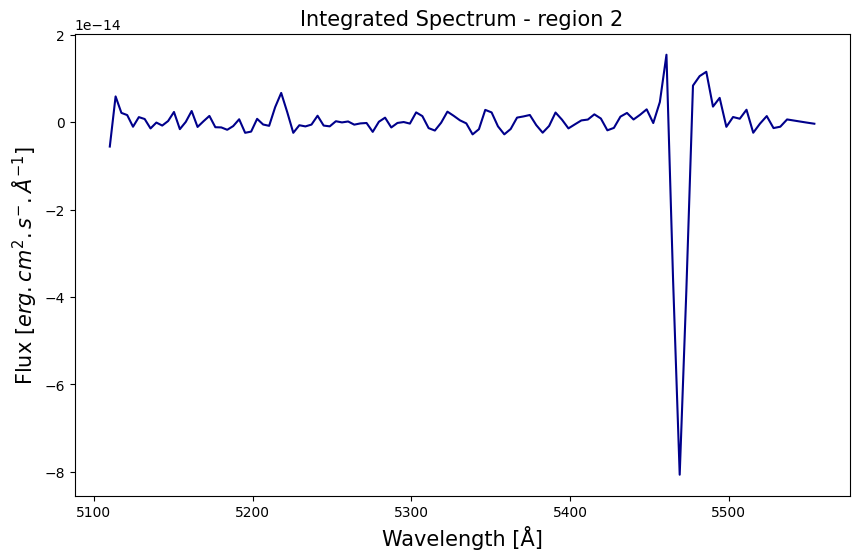

In [8]:
def plot_spectrum(integrated_spectrum, header,figname):
    filter_cm1_min = header['HIERARCH filter_cm1_min']
    filter_cm1_max = header['HIERARCH filter_cm1_max']
    step_nb = header['STEP_NB']

    wavenumber_axis = np.linspace(filter_cm1_min, filter_cm1_max, step_nb)
    wavelength_axis = 1e8 / wavenumber_axis  # Convert cm^-1 to Angstroms

    # Calculate the wavelength step size
    wavelength_step = np.abs(np.diff(wavelength_axis)).mean()  # Mean step size in Ångstroms

    # Convert integrated spectrum to erg/cm^2/s/Å
    integrated_spectrum_per_angstrom = integrated_spectrum / wavelength_step
    save_spectrum(wavelength_axis, integrated_spectrum_per_angstrom, 'region_1_spec.txt')

    plt.figure(figsize=(10, 6))
    plt.plot(wavelength_axis, integrated_spectrum_per_angstrom, label='Integrated Spectrum',color='darkblue')
    plt.xlabel('Wavelength [Å]',size=15)
    plt.ylabel('Flux [$erg.cm^2.s^{-}.{\AA}^{-1}$]',size=15)
    title = 'Integrated Spectrum - region ' + input('enter region number: ')
    plt.title(title, size=15)
    #plt.legend()
    #plt.grid(True)
    plt.savefig(figname)
    plt.show()
    
# Region 2
figname = '/home/lucas/LUCI/Examples/crab_c3_field1/Results_paper/spectrum_region2_final.jpeg'
region_file = '../Luci_outputs/field_1_regions_paper/region2.reg'  # Replace with your DS9 region file
regions = read_ds9_region(region_file)

with fits.open('continuum_subtracted.fits') as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

mask = extract_region_data(data_cube, regions, header)
integrated_spectrum = integrate_spectrum(data_cube, mask)
plot_spectrum(integrated_spectrum, header,figname)

100%|█████████████████████████████████████| 2064/2064 [00:00<00:00, 3657.00it/s]


enter region number: 1
include vertical line? no
no vertical line included


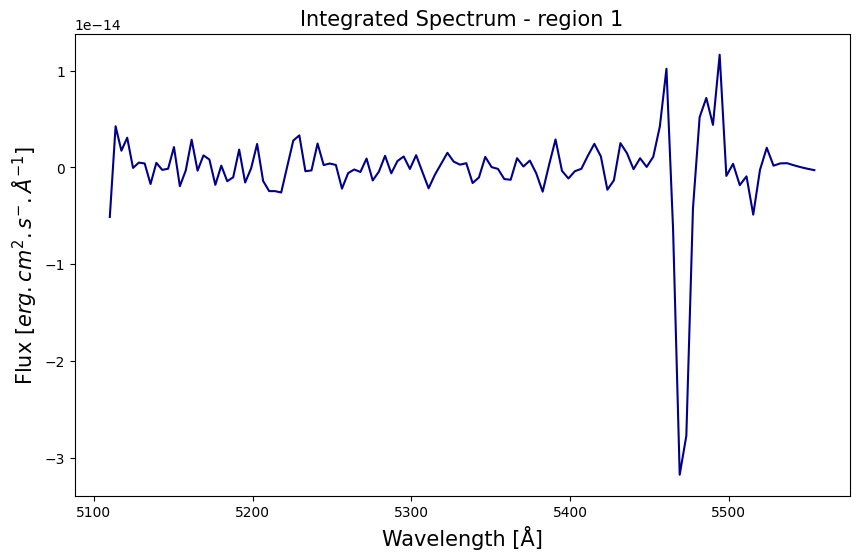

In [9]:
def plot_spectrum(integrated_spectrum, header,figname):
    filter_cm1_min = header['HIERARCH filter_cm1_min']
    filter_cm1_max = header['HIERARCH filter_cm1_max']
    step_nb = header['STEP_NB']

    wavenumber_axis = np.linspace(filter_cm1_min, filter_cm1_max, step_nb)
    wavelength_axis = 1e8 / wavenumber_axis  # Convert cm^-1 to Angstroms

    # Calculate the wavelength step size
    wavelength_step = np.abs(np.diff(wavelength_axis)).mean()  # Mean step size in Ångstroms

    # Convert integrated spectrum to erg/cm^2/s/Å
    integrated_spectrum_per_angstrom = integrated_spectrum / wavelength_step
    save_spectrum(wavelength_axis, integrated_spectrum_per_angstrom, 'region_1_spec.txt')

    plt.figure(figsize=(10, 6))
    plt.plot(wavelength_axis, integrated_spectrum_per_angstrom, label='Integrated Spectrum',color='darkblue')
    plt.xlabel('Wavelength [Å]',size=15)
    plt.ylabel('Flux [$erg.cm^2.s^{-}.{\AA}^{-1}$]',size=15)
    title = 'Integrated Spectrum - region ' + input('enter region number: ')
    answer = input('include vertical line? ')
    if answer == 'yes':
        where = float(input('type the coordinate in the x-axis where you want it: '))
        plt.axvline(x = where, color = 'b',linestyle='--', label = str(where))
    else:
        print('no vertical line included')
    plt.title(title, size=15)
    #plt.legend()
    #plt.grid(True)
    plt.savefig(figname)
    plt.show()



# Example usage
figname = '/home/lucas/LUCI/Examples/crab_c3_field1/Results_paper/spectrum_region1_final.jpeg'
region_file = '../Luci_outputs/field_1_regions_paper/region1.reg'  # Replace with your DS9 region file
regions = read_ds9_region(region_file)

with fits.open('continuum_subtracted.fits') as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

mask = extract_region_data(data_cube, regions, header)
integrated_spectrum = integrate_spectrum(data_cube, mask)
plot_spectrum(integrated_spectrum, header,figname)

100%|█████████████████████████████████████| 2064/2064 [00:00<00:00, 3654.51it/s]


enter region number: 2
include vertical line? n
no vertical line included


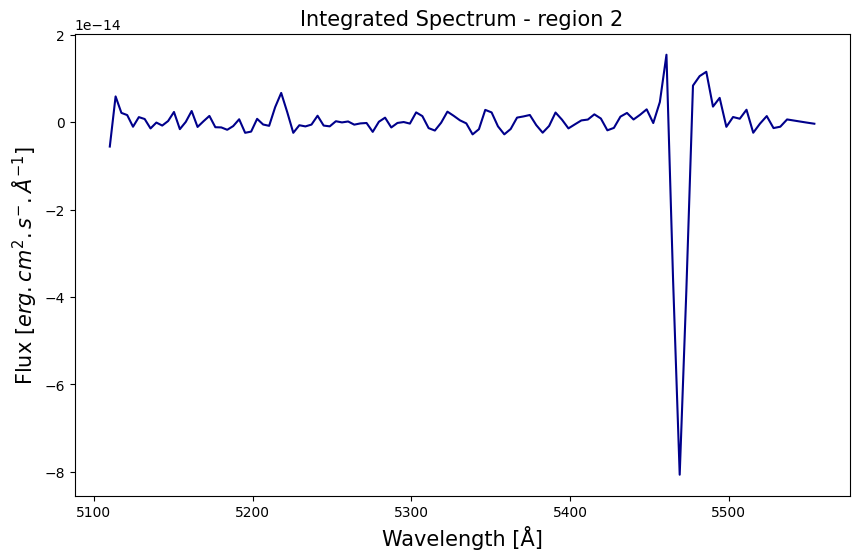

In [10]:
# Region 2
figname = '/home/lucas/LUCI/Examples/crab_c3_field1/Results_paper/spectrum_region2_final.jpeg'
region_file = '../Luci_outputs/field_1_regions_paper/region2.reg'  # Replace with your DS9 region file
regions = read_ds9_region(region_file)

with fits.open('continuum_subtracted.fits') as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

mask = extract_region_data(data_cube, regions, header)
integrated_spectrum = integrate_spectrum(data_cube, mask)
plot_spectrum(integrated_spectrum, header,figname)

100%|█████████████████████████████████████| 2064/2064 [00:00<00:00, 2397.00it/s]


enter region number: 3
include vertical line? no
no vertical line included


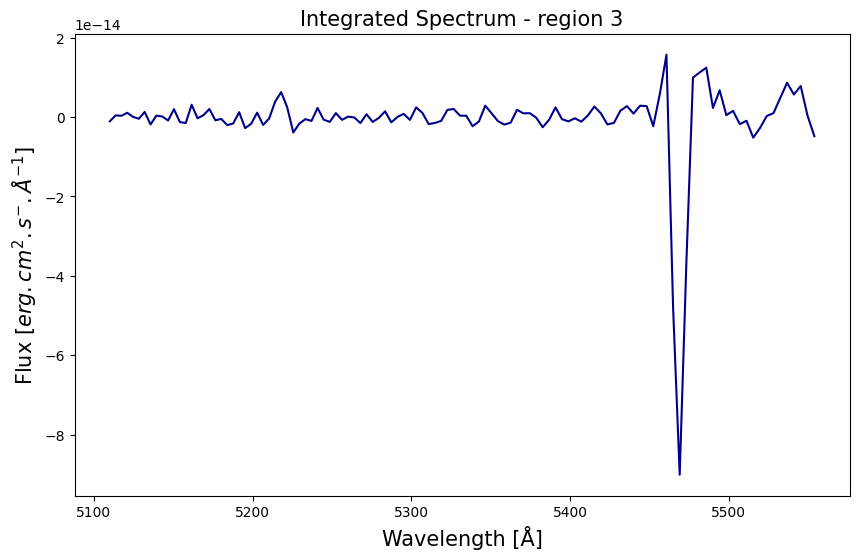

In [11]:
# Region 3
figname = '/home/lucas/LUCI/Examples/crab_c3_field1/Results_paper/spectrum_region3_final.jpeg'
region_file = '../Luci_outputs/field_1_regions_paper/region3.reg'  # Replace with your DS9 region file
regions = read_ds9_region(region_file)

with fits.open('continuum_subtracted.fits') as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

mask = extract_region_data(data_cube, regions, header)
integrated_spectrum = integrate_spectrum(data_cube, mask)
plot_spectrum(integrated_spectrum, header,figname)

100%|█████████████████████████████████████| 2064/2064 [00:00<00:00, 3675.53it/s]


enter region number: 4
include vertical line? n
no vertical line included


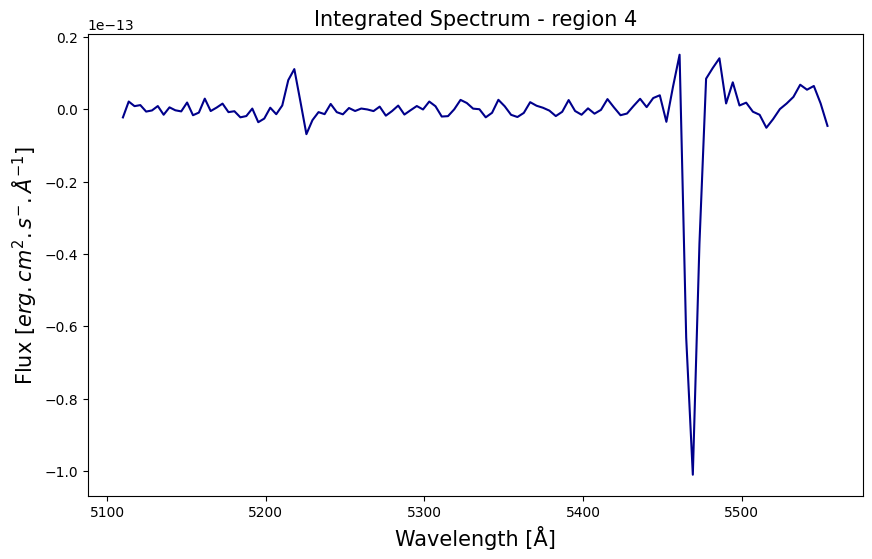

In [12]:
# Region 4
figname = '/home/lucas/LUCI/Examples/crab_c3_field1/Results_paper/spectrum_region4_final.jpeg'
region_file = '../Luci_outputs/field_1_regions_paper/region4.reg'  # Replace with your DS9 region file
regions = read_ds9_region(region_file)

with fits.open('continuum_subtracted.fits') as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

mask = extract_region_data(data_cube, regions, header)
integrated_spectrum = integrate_spectrum(data_cube, mask)
plot_spectrum(integrated_spectrum, header,figname)

100%|█████████████████████████████████████| 2064/2064 [00:00<00:00, 2336.91it/s]


enter region number: 5
include vertical line? n
no vertical line included


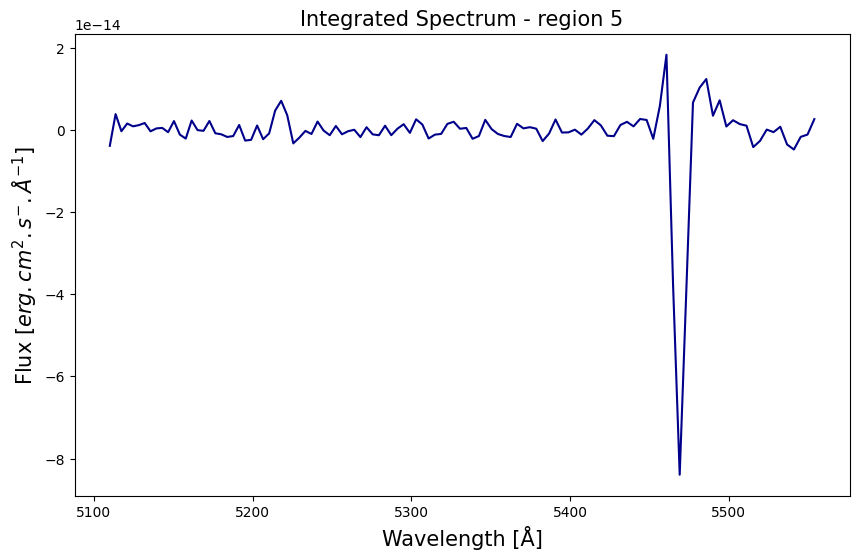

In [13]:
# Region 5
figname = '/home/lucas/LUCI/Examples/crab_c3_field1/Results_paper/spectrum_region5_final.jpeg'
region_file = '../Luci_outputs/field_1_regions_paper/region5.reg'  # Replace with your DS9 region file
regions = read_ds9_region(region_file)

with fits.open('continuum_subtracted.fits') as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

mask = extract_region_data(data_cube, regions, header)
integrated_spectrum = integrate_spectrum(data_cube, mask)
plot_spectrum(integrated_spectrum, header,figname)

100%|█████████████████████████████████████| 2064/2064 [00:00<00:00, 3221.49it/s]


enter region number: 6
include vertical line? n
no vertical line included


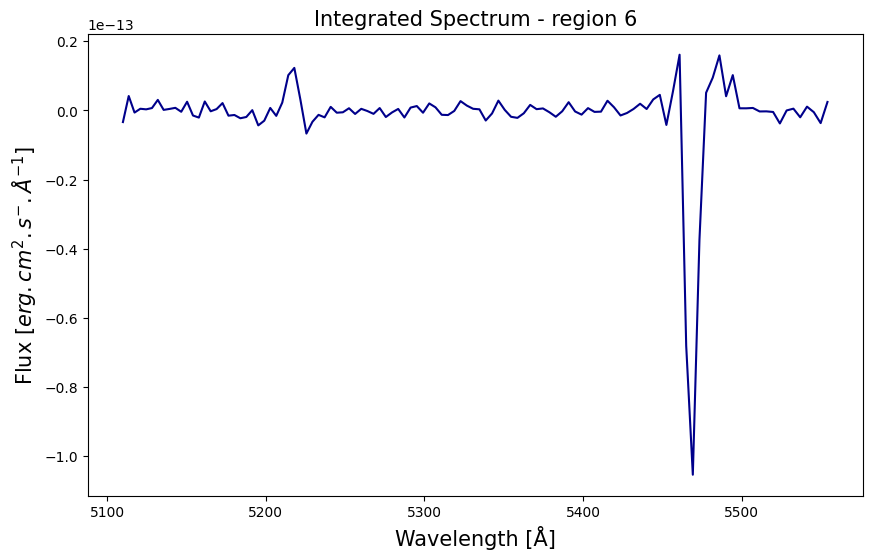

In [14]:
# Region 6
figname = '/home/lucas/LUCI/Examples/crab_c3_field1/Results_paper/spectrum_region6_final.jpeg'
region_file = '../Luci_outputs/field_1_regions_paper/region6.reg'  # Replace with your DS9 region file
regions = read_ds9_region(region_file)

with fits.open('continuum_subtracted.fits') as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

mask = extract_region_data(data_cube, regions, header)
integrated_spectrum = integrate_spectrum(data_cube, mask)
plot_spectrum(integrated_spectrum, header,figname)

100%|█████████████████████████████████████| 2064/2064 [00:00<00:00, 3465.90it/s]


enter region number: 7
include vertical line? no
no vertical line included


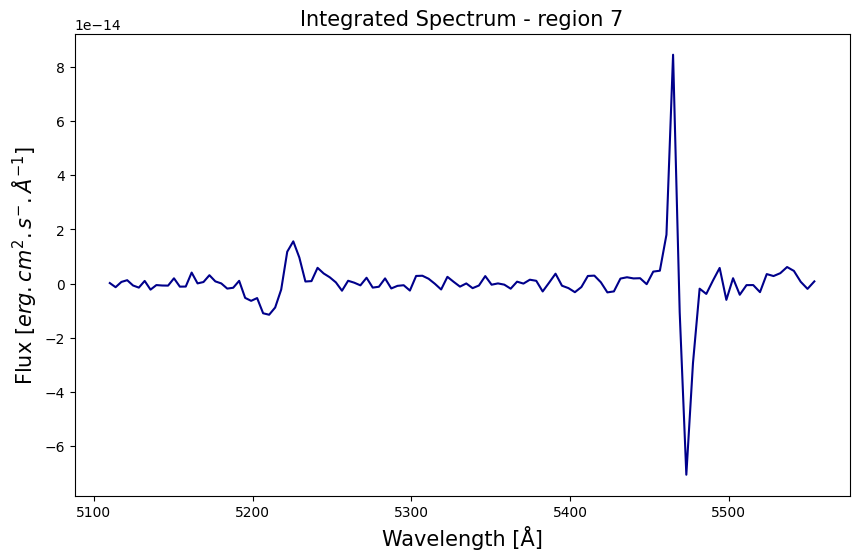

In [15]:
# Region 7
figname = '/home/lucas/LUCI/Examples/crab_c3_field1/Results_paper/spectrum_region7_final.jpeg'
region_file = '../Luci_outputs/field_1_regions_paper/region7.reg'  # Replace with your DS9 region file
regions = read_ds9_region(region_file)

with fits.open('continuum_subtracted.fits') as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

mask = extract_region_data(data_cube, regions, header)
integrated_spectrum = integrate_spectrum(data_cube, mask)
plot_spectrum(integrated_spectrum, header,figname)

## Apply slicing

5214.616666666667
Image saved to iron_slice_-5000_final.fits
Velocity range: -5000 km/s
Emission line: 5303 Å
INFO: Auto-setting vmin to -5.621e-18 [aplpy.core]
INFO: Auto-setting vmax to  4.985e-18 [aplpy.core]


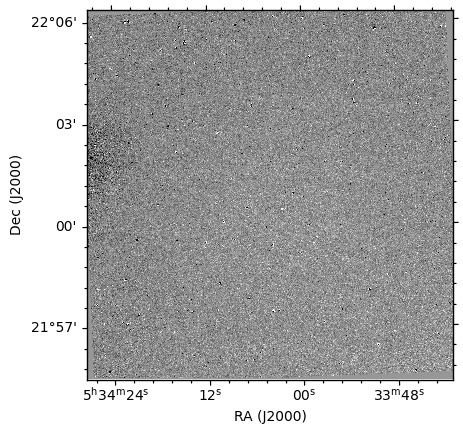

5260.576
Image saved to iron_slice_-2400_final.fits
Velocity range: -2400 km/s
Emission line: 5303 Å
INFO: Auto-setting vmin to -4.603e-18 [aplpy.core]
INFO: Auto-setting vmax to  4.118e-18 [aplpy.core]


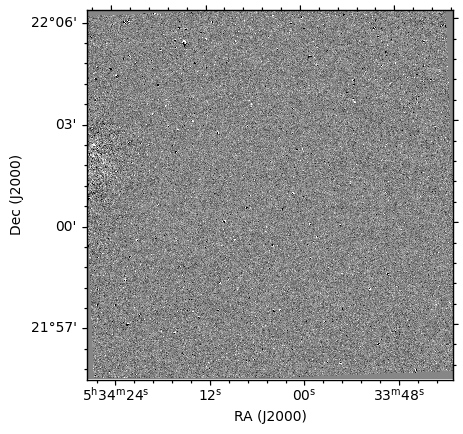

5303.0
Image saved to iron_slice_0_final.fits
Velocity range: 0 km/s
Emission line: 5303 Å
INFO: Auto-setting vmin to -3.715e-18 [aplpy.core]
INFO: Auto-setting vmax to  4.503e-18 [aplpy.core]


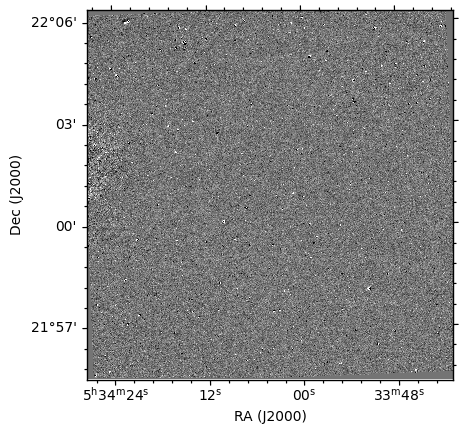

5345.424
Image saved to iron_slice_2400_final.fits
Velocity range: 2400 km/s
Emission line: 5303 Å
INFO: Auto-setting vmin to -3.423e-18 [aplpy.core]
INFO: Auto-setting vmax to  4.114e-18 [aplpy.core]


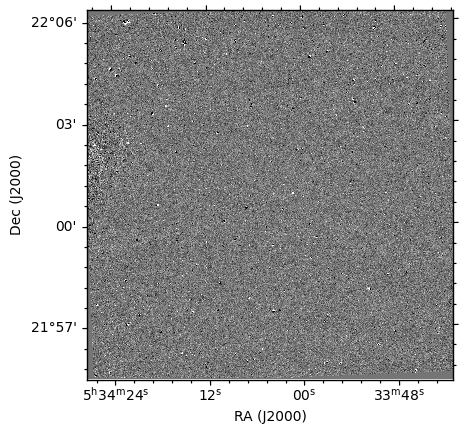

5391.383333333333
Image saved to iron_slice_5000_final.fits
Velocity range: 5000 km/s
Emission line: 5303 Å
INFO: Auto-setting vmin to -3.745e-18 [aplpy.core]
INFO: Auto-setting vmax to  4.288e-18 [aplpy.core]


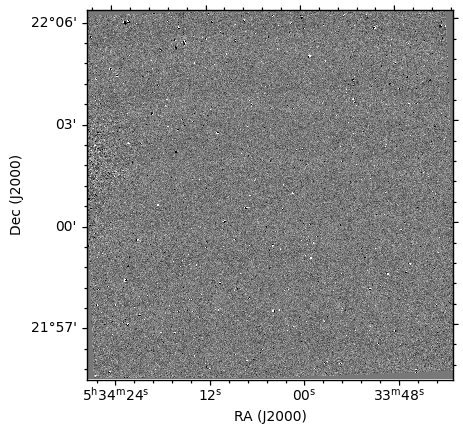

In [90]:
# Create [Fe XIV] images of different velocities 
def convert_fits_to_image(fits_file, emission_line, velocity, output_file):
    # Open the FITS file and load the data
    with fits.open(fits_file) as hdul:
        data_cube = hdul[0].data
        header = hdul[0].header
               
    # Converting velocity input to wavelength 
    lam = (velocity*emission_line/(3e5)) + emission_line
    print(lam)

    # Converting wavenumber to wavelength
    filter_cm1_min = header['HIERARCH filter_cm1_min']
    filter_cm1_max = header['HIERARCH filter_cm1_max']
    step_nb = header['STEP_NB']

    wavenumber_axis = np.linspace(filter_cm1_min, filter_cm1_max, step_nb)
    wavelength_axis = 1e8 / wavenumber_axis  # Convert cm^-1 to Angstroms

    # Find the channel that correspond to the velocity input    
    image_0 = data_cube[(wavelength_axis>=np.floor(lam)-2)*(wavelength_axis<=np.floor(lam)+2),:,:]
    image_data = np.sum(image_0, axis=0)

    # Update the header for 2D image data
    new_header = header.copy()
    new_header['NAXIS'] = 2
    new_header['NAXIS1'] = image_data.shape[1]
    new_header['NAXIS2'] = image_data.shape[0]

    # Remove 3D-specific keywords, if they exist
    keys_to_remove = ['CTYPE3', 'CRPIX3', 'CRVAL3', 'CDELT3', 'WCSAXES', 'NAXIS3']
    for key in keys_to_remove:
        if key in new_header:
            del new_header[key]

    # Add custom metadata related to the velocity range and other parameters
    new_header['VELO_MIN'] = velocity
    #new_header['VELO_MAX'] = velocity_range[1]
    new_header['EMLINE'] = emission_line
    new_header['SLICE_CT'] = 1  # Since we're working with a single slice here
    new_header['COMMENT'] = "Velocity slice image"

    # Save the 2D image FITS file
    fits.writeto(output_file, image_data, new_header, overwrite=True)

    # Print out information for the user
    print(f"Image saved to {output_file}")
    print(f"Velocity range: {velocity} km/s")
    print(f"Emission line: {emission_line} Å")

    # Visualize the slice using aplpy
    fig = plt.figure()
    f = aplpy.FITSFigure(output_file, figure=fig)
    f.show_grayscale()
    plt.show()

# Example usage
fits_file = 'continuum_subtracted.fits'
emission_line = 5303  # Angstroms
velocities = [-5000,-2400,0,2400,5000]  # km/s
#output_file = 'iron_slice_2400_final.fits'
#continuum_subtracted.fits
for velocity in velocities:
    convert_fits_to_image(fits_file, emission_line, velocity, 'iron_slice_' + str(velocity) +'_final.fits')

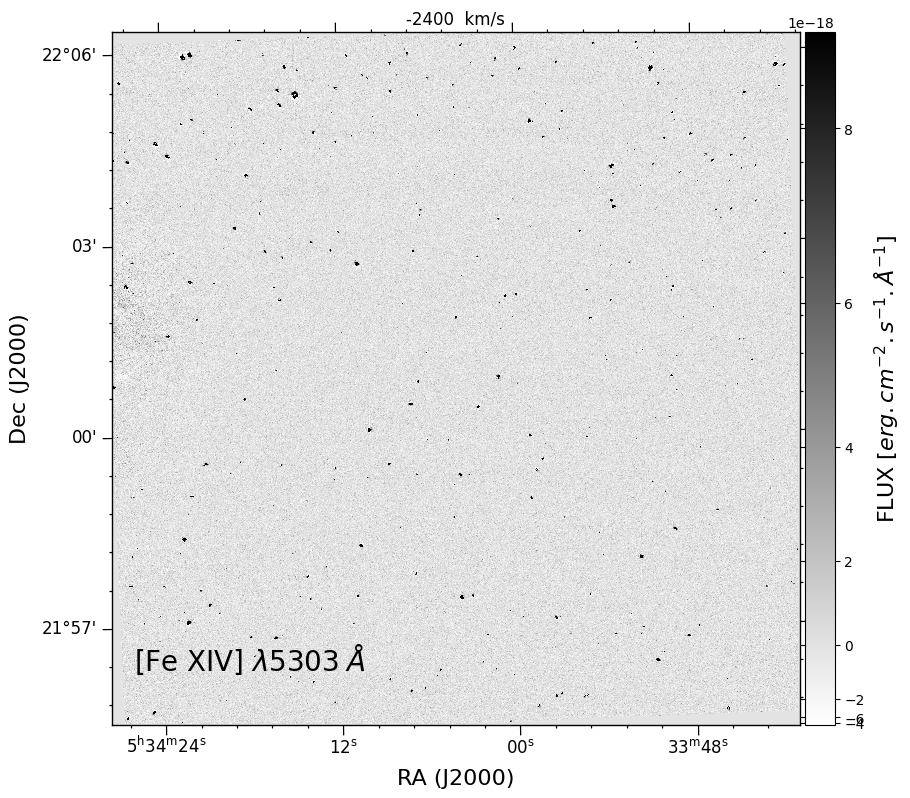

In [108]:
hh = aplpy.FITSFigure('iron_slice_-2400_final.fits')
#min_val, max_val = np.percentile(data, [2.5, 95.5])
hh.show_grayscale(vmin=-4.603e-18 , vmax= 8.985e-18
                  ,stretch= 'power')
                  # can add here inverted = True
hh.set_theme('publication')
hh.axis_labels.set_font(size=16)
hh.tick_labels.set_font(size=12)

#hh.add_grid()
#hh.add_label(0.1, 0.15, 'Field 1', relative=True,size=18)
hh.add_colorbar()
hh.colorbar.set_width(0.3)
hh.colorbar.set_location('right')
hh.colorbar.set_axis_label_text('FLUX [$erg.cm^{-2}.s^{-1}.{\AA}^{-1}$]')
hh.colorbar.set_axis_label_font(size=16)
#hh.show_regions('../Luci_outputs/paper.reg', layer=False)
hh.set_title('-2400  km/s')
hh.add_label(0.2, 0.095, '[Fe XIV] $\lambda5303 \; {\AA}$', relative=True,size=20)
#hh.add_label(0.2, 0.045, '-2400 to 2400 km/s', relative=True,size=15)
hh.save('iron_slice_-2400_final_.jpeg')

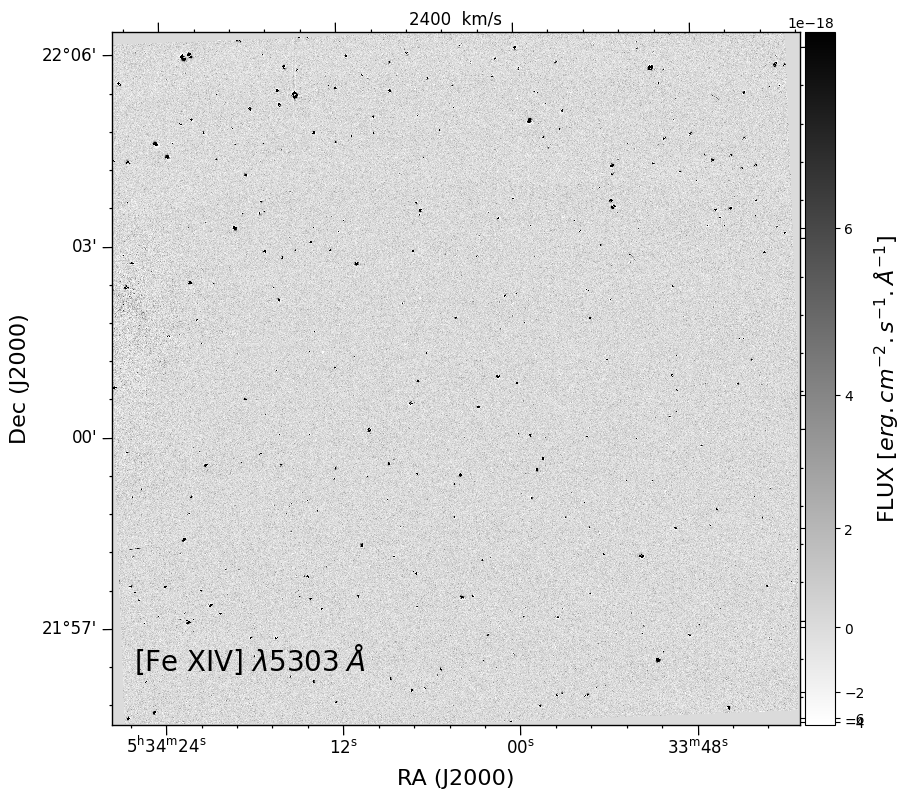

In [109]:
hh = aplpy.FITSFigure('iron_slice_2400_final.fits')
#min_val, max_val = np.percentile(data, [2.5, 95.5])
hh.show_grayscale(vmin=-4.757e-18 , vmax= 7.945e-18
                  ,stretch= 'power')
                  # can add here inverted = True
hh.set_theme('publication')
hh.axis_labels.set_font(size=16)
hh.tick_labels.set_font(size=12)

#hh.add_grid()
#hh.add_label(0.1, 0.15, 'Field 1', relative=True,size=18)
hh.add_colorbar()
hh.colorbar.set_width(0.3)
hh.colorbar.set_location('right')
hh.colorbar.set_axis_label_text('FLUX [$erg.cm^{-2}.s^{-1}.{\AA}^{-1}$]')
hh.colorbar.set_axis_label_font(size=16)
#hh.show_regions('../Luci_outputs/paper.reg', layer=False)
hh.set_title('2400  km/s')
hh.add_label(0.2, 0.095, '[Fe XIV] $\lambda5303 \; {\AA}$', relative=True,size=20)
#hh.add_label(0.2, 0.045, '-2400 to 2400 km/s', relative=True,size=15)
hh.save('iron_slice_2400_final_.jpeg')

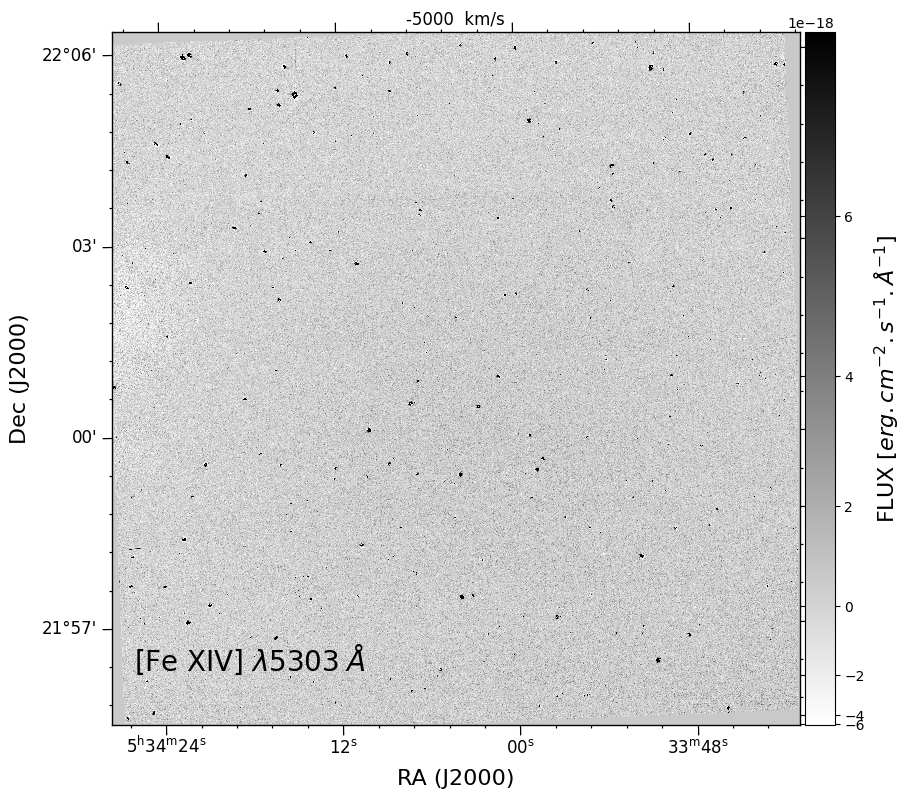

In [110]:
hh = aplpy.FITSFigure('iron_slice_-5000_final.fits')
#min_val, max_val = np.percentile(data, [2.5, 95.5])
hh.show_grayscale(vmin=-5.621e-18 , vmax= 7.945e-18
                  ,stretch= 'power')
                  # can add here inverted = True
hh.set_theme('publication')
hh.axis_labels.set_font(size=16)
hh.tick_labels.set_font(size=12)

#hh.add_grid()
#hh.add_label(0.1, 0.15, 'Field 1', relative=True,size=18)
hh.add_colorbar()
hh.colorbar.set_width(0.3)
hh.colorbar.set_location('right')
hh.colorbar.set_axis_label_text('FLUX [$erg.cm^{-2}.s^{-1}.{\AA}^{-1}$]')
hh.colorbar.set_axis_label_font(size=16)
#hh.show_regions('../Luci_outputs/paper.reg', layer=False)
hh.set_title('-5000  km/s')
hh.add_label(0.2, 0.095, '[Fe XIV] $\lambda5303 \; {\AA}$', relative=True,size=20)
#hh.add_label(0.2, 0.045, '-2400 to 2400 km/s', relative=True,size=15)
hh.save('iron_slice_-5000_final_.jpeg')

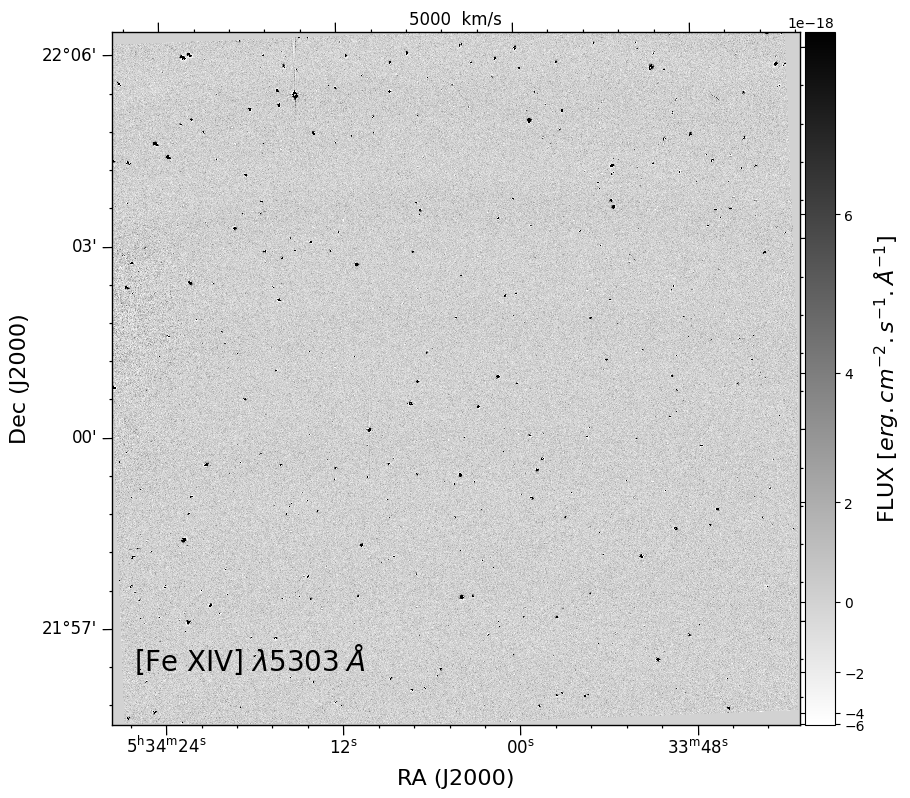

In [112]:
hh = aplpy.FITSFigure('iron_slice_5000_final.fits')
#min_val, max_val = np.percentile(data, [2.5, 95.5])
hh.show_grayscale(vmin=-5.757e-18 , vmax= 7.945e-18
                  ,stretch= 'power')
                  # can add here inverted = True
hh.set_theme('publication')
hh.axis_labels.set_font(size=16)
hh.tick_labels.set_font(size=12)

#hh.add_grid()
#hh.add_label(0.1, 0.15, 'Field 1', relative=True,size=18)
hh.add_colorbar()
hh.colorbar.set_width(0.3)
hh.colorbar.set_location('right')
hh.colorbar.set_axis_label_text('FLUX [$erg.cm^{-2}.s^{-1}.{\AA}^{-1}$]')
hh.colorbar.set_axis_label_font(size=16)
#hh.show_regions('../Luci_outputs/paper.reg', layer=False)
hh.set_title('5000  km/s')
hh.add_label(0.2, 0.095, '[Fe XIV] $\lambda5303 \; {\AA}$', relative=True,size=20)
#hh.add_label(0.2, 0.045, '-2400 to 2400 km/s', relative=True,size=15)
hh.save('iron_slice_5000_final_.jpeg')

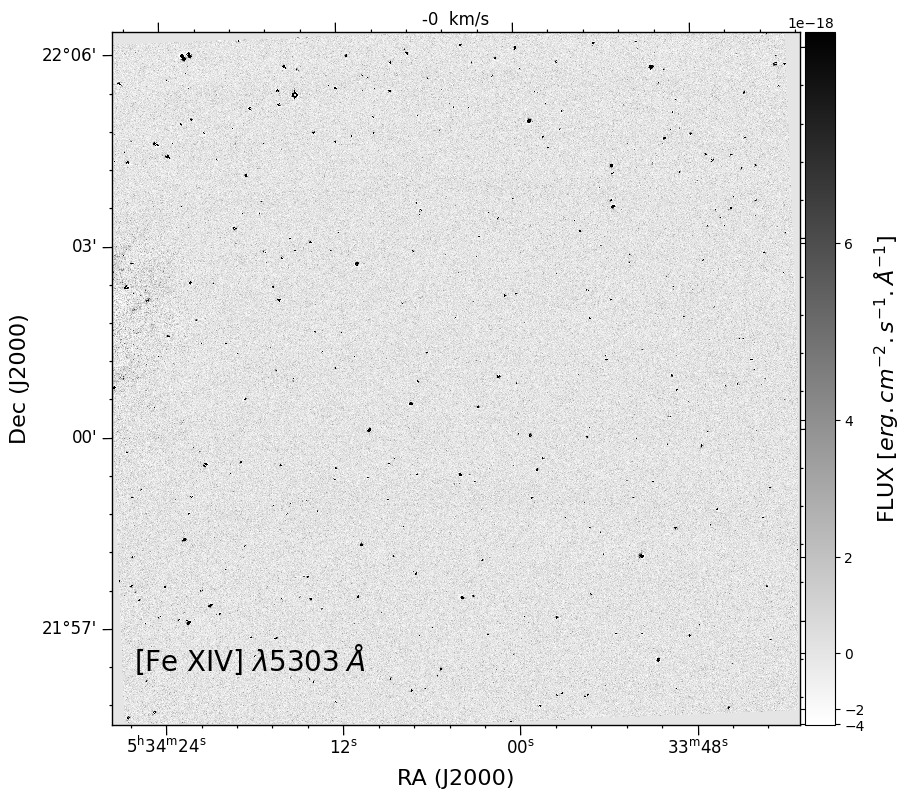

In [97]:
hh = aplpy.FITSFigure('iron_slice_0_final.fits')
#min_val, max_val = np.percentile(data, [2.5, 95.5])
hh.show_grayscale(vmin=-3.757e-18 , vmax= 7.945e-18
                  ,stretch= 'power')
                  # can add here inverted = True
hh.set_theme('publication')
hh.axis_labels.set_font(size=16)
hh.tick_labels.set_font(size=12)

#hh.add_grid()
#hh.add_label(0.1, 0.15, 'Field 1', relative=True,size=18)
hh.add_colorbar()
hh.colorbar.set_width(0.3)
hh.colorbar.set_location('right')
hh.colorbar.set_axis_label_text('FLUX [$erg.cm^{-2}.s^{-1}.{\AA}^{-1}$]')
hh.colorbar.set_axis_label_font(size=16)
#hh.show_regions('../Luci_outputs/paper.reg', layer=False)
hh.set_title('-0  km/s')
hh.add_label(0.2, 0.095, '[Fe XIV] $\lambda5303 \; {\AA}$', relative=True,size=20)
#hh.add_label(0.2, 0.045, '-2400 to 2400 km/s', relative=True,size=15)
hh.save('iron_slice_0_final_.jpeg')

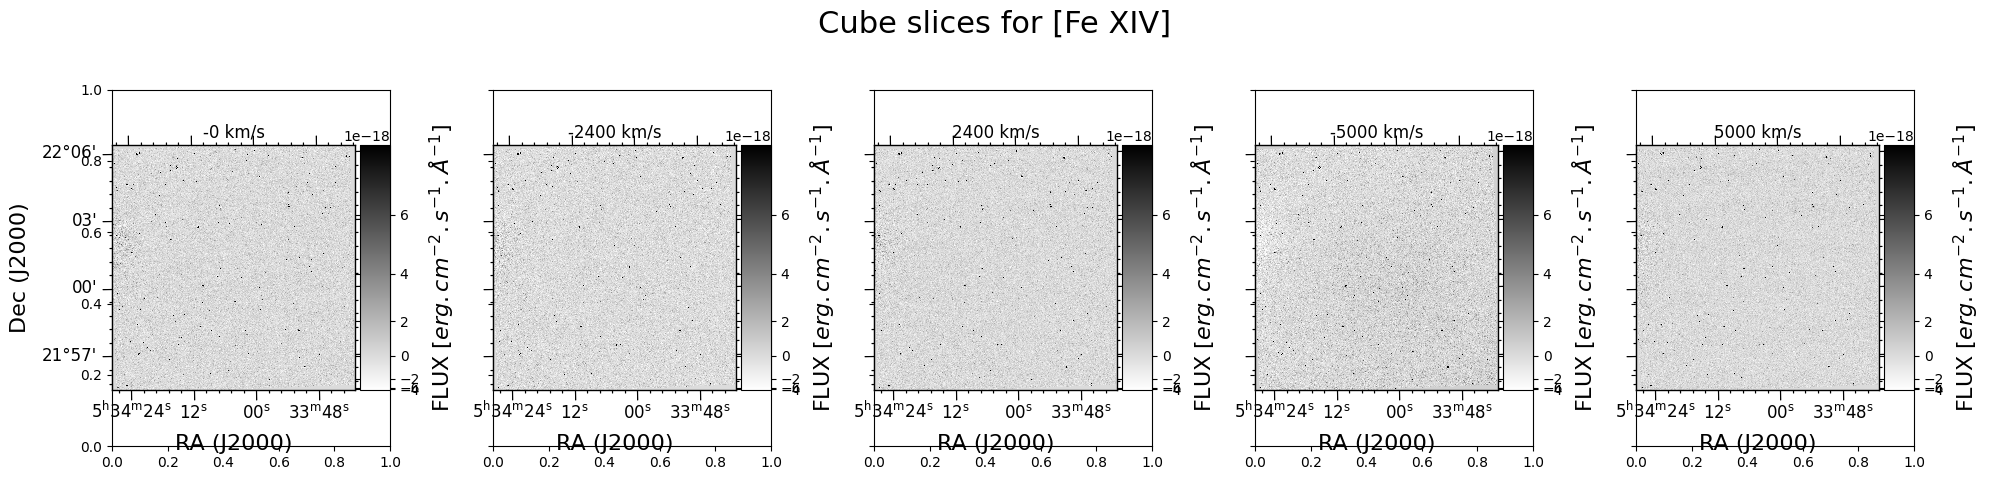

In [118]:
# List of your FITS files and titles for each subplot
files = ['iron_slice_0_final.fits', 'iron_slice_-2400_final.fits', 'iron_slice_2400_final.fits', 'iron_slice_-5000_final.fits', 'iron_slice_5000_final.fits']
titles = ['-0 km/s', '-2400 km/s', '2400 km/s', '-5000 km/s', '5000 km/s']

# Set up a 1x5 figure
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True,sharex=True)  # sharey=True keeps a single y-axis

# Main title for the whole figure
fig.suptitle('Cube slices for [Fe XIV]', fontsize=22)

for i, (file, title) in enumerate(zip(files, titles)):
    hh = aplpy.FITSFigure(file, figure=fig, subplot=(1, 5, i + 1))
    hh.show_grayscale(vmin=-4.757e-18, vmax=7.945e-18, stretch='power')
    hh.set_theme('publication')
    hh.axis_labels.set_font(size=16)
    hh.tick_labels.set_font(size=12)
    
    # Hide y-axis for all but the first subplot
    if i > 0:
        hh.axis_labels.hide_y()
        hh.tick_labels.hide_y()

    
    hh.add_colorbar()
    hh.colorbar.set_width(0.3)
    hh.colorbar.set_location('right')
    hh.colorbar.set_axis_label_text('FLUX [$erg.cm^{-2}.s^{-1}.{\AA}^{-1}$]')
    hh.colorbar.set_axis_label_font(size=16)
    hh.set_title(title)
    #hh.add_label(0.2, 0.095, '[Fe XIV] $\lambda5303 \; {\AA}$', relative=True, size=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit main title
plt.savefig('iron_slice_combined.jpeg', dpi=300)
plt.show()

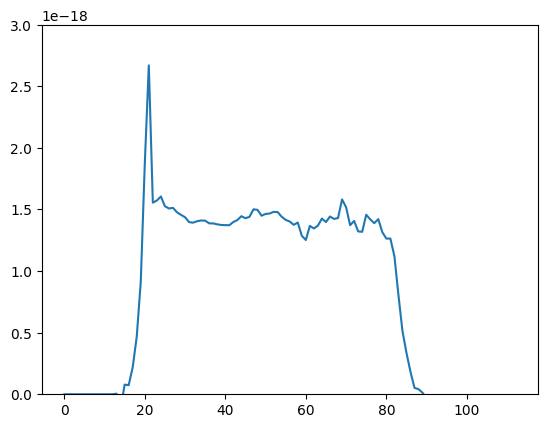

In [6]:
plt.plot(sky_spec)
plt.ylim(0,3e-18)
plt.show()